<a href="https://colab.research.google.com/github/jhyun90/DL-with-fastai/blob/master/fastai_image_segmentation_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
path = untar_data(URLs.CAMVID)

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [33]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f02880.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07920.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008910.png')]

In [34]:
label_names = get_image_files(path_lbl)
label_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_05370_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_05310_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04380_P.png')]

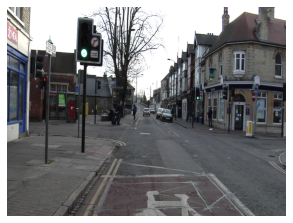

In [36]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
img.data

tensor([[[0.2392, 0.2353, 0.2275,  ..., 0.0784, 0.0902, 0.0863],
         [0.2353, 0.2314, 0.2275,  ..., 0.0745, 0.0863, 0.0745],
         [0.2353, 0.2392, 0.2314,  ..., 0.0667, 0.0745, 0.0706],
         ...,
         [0.0745, 0.0745, 0.0706,  ..., 0.1216, 0.1059, 0.1059],
         [0.0706, 0.0745, 0.0706,  ..., 0.1137, 0.0980, 0.0941],
         [0.0667, 0.0706, 0.0667,  ..., 0.0980, 0.0863, 0.0824]],

        [[0.2824, 0.2784, 0.2706,  ..., 0.0941, 0.0902, 0.0863],
         [0.2706, 0.2667, 0.2706,  ..., 0.0902, 0.0902, 0.0784],
         [0.2706, 0.2745, 0.2745,  ..., 0.0824, 0.0784, 0.0745],
         ...,
         [0.0745, 0.0745, 0.0745,  ..., 0.1529, 0.1451, 0.1451],
         [0.0706, 0.0745, 0.0745,  ..., 0.1529, 0.1373, 0.1333],
         [0.0667, 0.0706, 0.0706,  ..., 0.1373, 0.1333, 0.1294]],

        [[0.2667, 0.2627, 0.2549,  ..., 0.0980, 0.1176, 0.1137],
         [0.2588, 0.2549, 0.2549,  ..., 0.0941, 0.1059, 0.0941],
         [0.2588, 0.2627, 0.2588,  ..., 0.0863, 0.0941, 0.

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

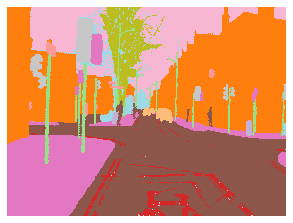

In [38]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [40]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [41]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

# Creating a data bunch

In [0]:
bs = 8
src_size = np.array(mask.size)
size = src_size//2

In [0]:
src = (SegmentationItemList
       .from_folder(path_img)
       .split_by_fname_file(path/'valid.txt')
       .label_from_func(get_y_fn,  classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

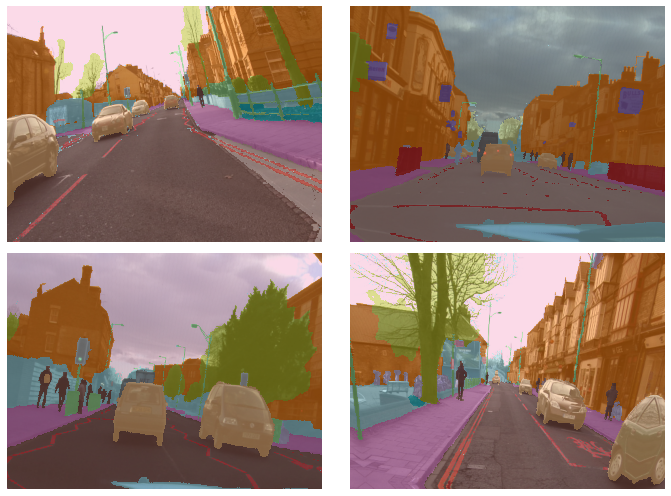

In [46]:
data.show_batch(2, figsize=(10,7))

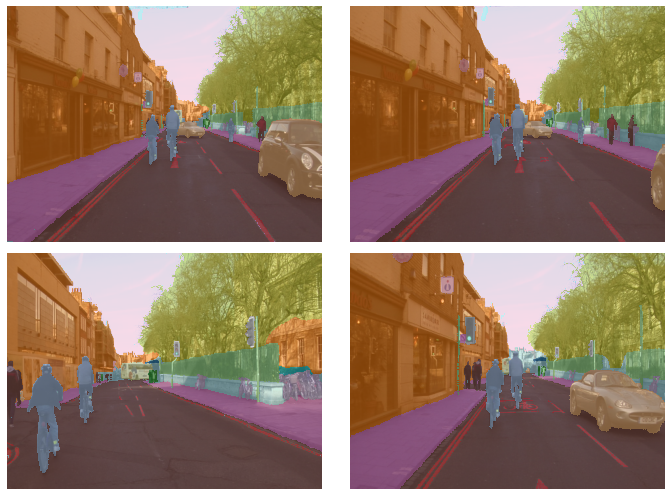

In [47]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Training

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [52]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


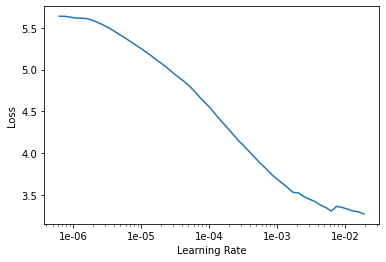

In [53]:
learn.recorder.plot()

In [0]:
lr=3e-3

In [55]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.273110,0.911049,0.771777,00:52
1,0.887155,0.796743,0.799627,00:49
2,0.747121,0.639021,0.845909,00:49
3,0.641962,0.651739,0.823226,00:49
4,0.625677,0.486906,0.867874,00:49
5,0.598903,0.507189,0.862151,00:48
6,0.577193,0.550608,0.870853,00:49
7,0.552673,0.461448,0.877862,00:49
8,0.515265,0.506622,0.860947,00:48
9,0.467271,0.339525,0.897690,00:49


In [0]:
learn.save('camvid-detection-stage-1')

# Model fine-tuning (Unfreezing, Fine-tuning and Differential Learning Rate)

In [57]:
learn.load('camvid-detection-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

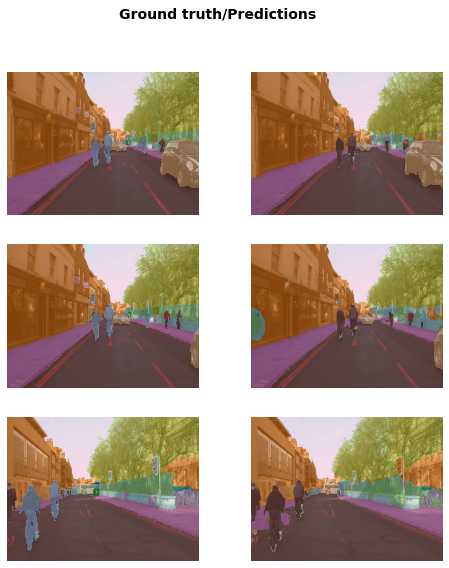

In [58]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400, lr/4)

In [61]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.399632,0.328837,0.898388,00:51
1,0.389162,0.321776,0.901213,00:50
2,0.375547,0.314437,0.906711,00:51
3,0.362001,0.315233,0.906421,00:51
4,0.350094,0.305761,0.912016,00:50
5,0.346257,0.298062,0.916755,00:50
6,0.333079,0.322693,0.908027,00:51
7,0.326269,0.307564,0.915426,00:50
8,0.326831,0.310426,0.912851,00:50
9,0.312880,0.273574,0.924306,00:51


In [0]:
learn.save('camvid-detection-stage-2')

In [70]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
learn.export('camvid-detection-stage-2.pkl')

In [69]:
import os
plt.rcParams.update({'figure.max_open_warning': 0}) # avoid matplotlib warnings
rest = load_learner(path, 'camvid-detection-stage-2.pkl') # load our pre-trained model we just exported

for filename in os.listdir(path/'test'):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        img = open_image('test/' + filename)
        img = img.apply_tfms(tfms=get_transforms()[1], size=224, resize_method=3) # resize the images the same way as the pre-processing
        preds, idx, output = rest.predict(img) # get predictions for each class and show only the one > to our threshold
        d = dict({rest.data.classes[i]: round(to_np(p)*100,2) for i, p in enumerate(output) if p > 0.2})
        img.show(title=str(d))

FileNotFoundError: ignored